In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [ ]:
# We will set the seed for reproducibility.
np.random.seed(1234)
PYTHONHASHSEED = 0

In [ ]:

# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('/content/AHM_train.csv', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('/content/AHM_test.csv', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [ ]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [ ]:
print(len(train_df))
print(len(test_df))

20631
13096


In [ ]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('/content/AHM_truth.csv', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [ ]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


<Axes: xlabel='0', ylabel='0'>

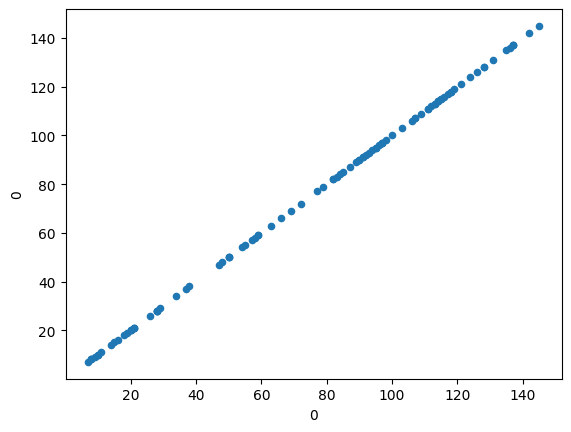

In [ ]:
# @title Scatter plot of X vs Y

truth_df.plot.scatter(x=0, y=0)

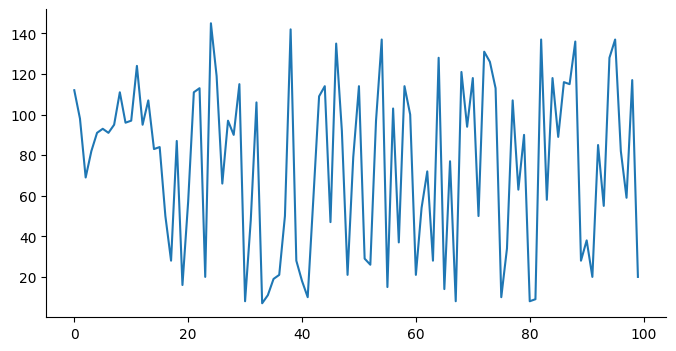

In [ ]:
# @title 0

from matplotlib import pyplot as plt
truth_df[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

In [ ]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [ ]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df.head(20)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,186,0
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,185,0
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,184,0
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,183,0
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,182,0


In [ ]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [ ]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [ ]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']
train_df.head()

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


In [ ]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


<Axes: >

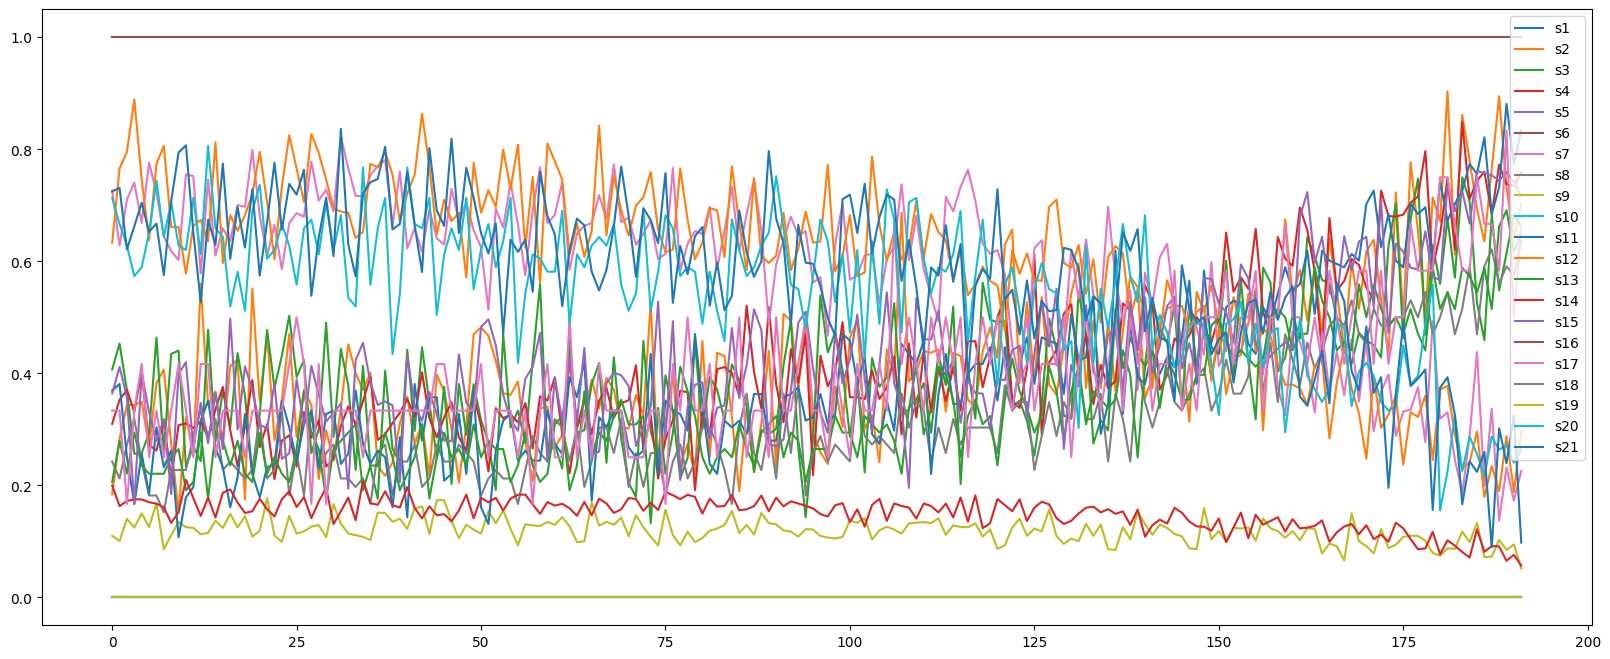

In [ ]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

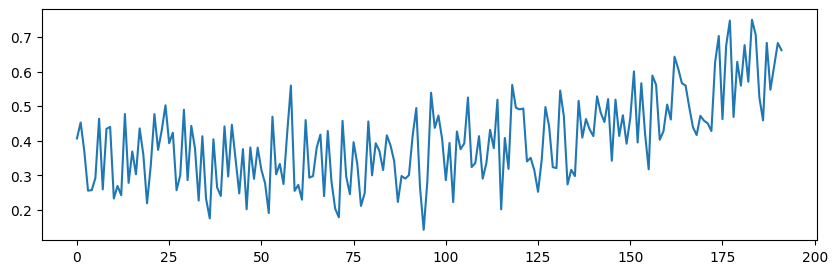

In [ ]:
train_df[train_df.id==1][sensor_cols[2]].plot(figsize=(10, 3))

<Axes: >

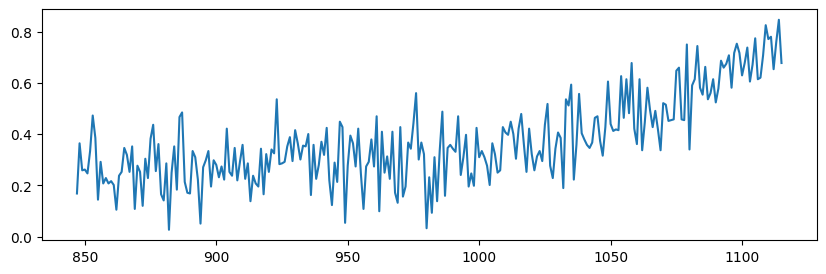

In [ ]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

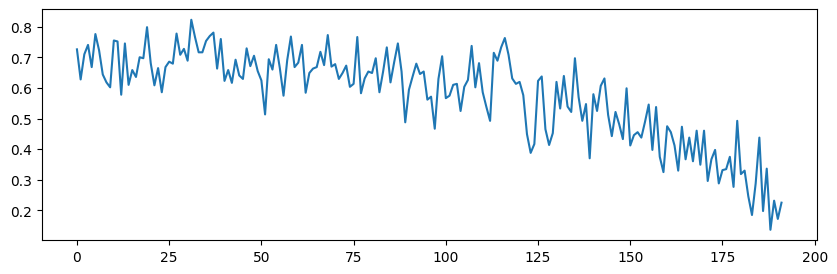

In [ ]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

<Axes: >

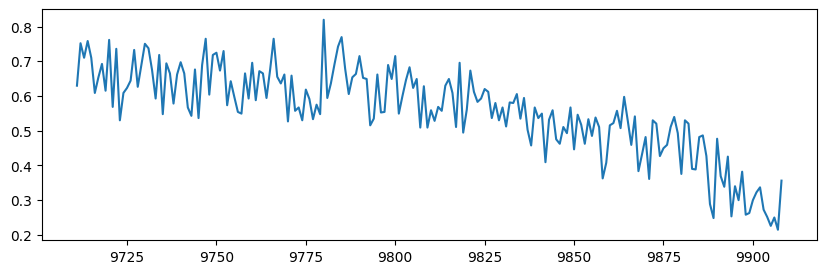

In [ ]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

In [ ]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [ ]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [ ]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [ ]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

In [ ]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = '/kaggle/working/RNN_fwd.h5'

Features dimension:  1
Output dimension:  1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1)                 3         
                                                                 
 dropout_7 (Dropout)         (None, 1)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import time
epochs = 300
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 2s - loss: 0.6274 - accuracy: 0.8017 - val_loss: 0.6073 - val_accuracy: 0.8018 - 2s/epoch - 29ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 1s - loss: 0.5953 - accuracy: 0.8017 - val_loss: 0.5784 - val_accuracy: 0.8018 - 731ms/epoch - 10ms/step
Epoch 3/300
75/75 - 1s - loss: 0.5716 - accuracy: 0.8017 - val_loss: 0.5565 - val_accuracy: 0.8018 - 619ms/epoch - 8ms/step
Epoch 4/300
75/75 - 1s - loss: 0.5530 - accuracy: 0.8017 - val_loss: 0.5402 - val_accuracy: 0.8018 - 611ms/epoch - 8ms/step
Epoch 5/300
75/75 - 1s - loss: 0.5394 - accuracy: 0.8017 - val_loss: 0.5285 - val_accuracy: 0.8018 - 647ms/epoch - 9ms/step
Epoch 6/300
75/75 - 1s - loss: 0.5311 - accuracy: 0.8017 - val_loss: 0.5197 - val_accuracy: 0.8018 - 701ms/epoch - 9ms/step
Epoch 7/300
75/75 - 1s - loss: 0.5259 - accuracy: 0.8017 - val_loss: 0.5139 - val_accuracy: 0.8018 - 691ms/epoch - 9ms/step
Epoch 8/300
75/75 - 1s - loss: 0.5204 - accuracy: 0.8017 - val_loss: 0.5095 - val_accuracy: 0.8018 - 667ms/epoch - 9ms/step
Epoch 9/300
75/75 - 1s - loss: 0.5189 - accuracy: 0.8017 - val_loss: 0.5066 - val_accuracy: 0.8018 - 614ms/epoch - 8ms/step
Epoch 10/300
75/75 

In [ ]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

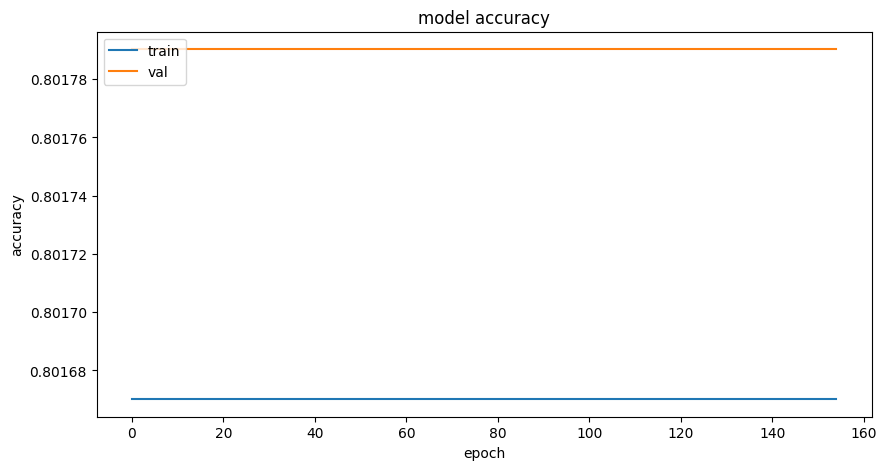

In [ ]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

In [ ]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

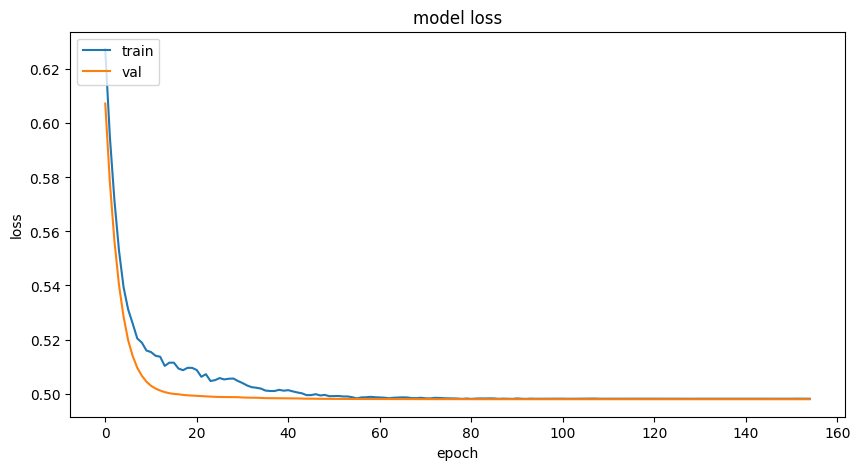

In [ ]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

In [ ]:

def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 [==============================] - 1s 3ms/step - loss: 0.4981 - accuracy: 0.8017
Train Accurracy: 0.8016761541366577
79/79 [==============================] - 0s 3ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12531     0]
 [ 3100     0]]
Train Precision =  0.0 
 Train Recall =  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()

using /kaggle/working/RNN_fwd.h5
3/3 - 0s - loss: 0.5966 - accuracy: 0.7312 - 379ms/epoch - 126ms/step
Total time taken for inferencing:  0.46  secs
Test Accurracy: 0.7311828136444092
3/3 [==============================] - 0s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [25  0]]
Test Precision:  0.0 
 Test Recall:  0.0 
 Test F1-score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-136-fe3b14b61455>:39: RuntimeWarning: invalid value encountered in scalar divide
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)


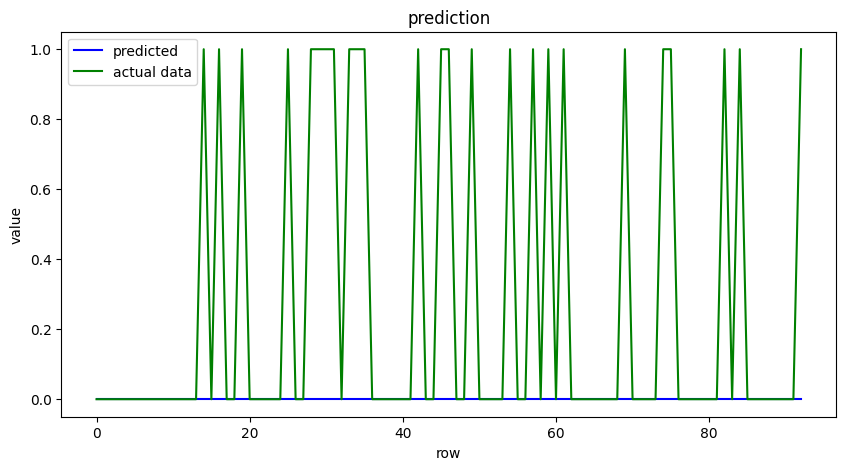

In [ ]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

In [ ]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [ ]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/kaggle/working/RNN_fwd_2.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 50, 5)             155       
                                                                 
 dropout_8 (Dropout)         (None, 50, 5)             0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_9 (Dropout)         (None, 3)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 186 (744.00 Byte)
Trainable params: 186 (744.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 4s - loss: 0.5456 - accuracy: 0.7478 - val_loss: 0.4304 - val_accuracy: 0.8171 - 4s/epoch - 59ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 2s - loss: 0.3829 - accuracy: 0.8673 - val_loss: 0.3112 - val_accuracy: 0.8990 - 2s/epoch - 24ms/step
Epoch 3/200
75/75 - 2s - loss: 0.2853 - accuracy: 0.9129 - val_loss: 0.2571 - val_accuracy: 0.9054 - 2s/epoch - 24ms/step
Epoch 4/200
75/75 - 2s - loss: 0.2453 - accuracy: 0.9248 - val_loss: 0.2406 - val_accuracy: 0.9169 - 2s/epoch - 23ms/step
Epoch 5/200
75/75 - 3s - loss: 0.2250 - accuracy: 0.9303 - val_loss: 0.2264 - val_accuracy: 0.9246 - 3s/epoch - 35ms/step
Epoch 6/200
75/75 - 2s - loss: 0.2136 - accuracy: 0.9291 - val_loss: 0.2274 - val_accuracy: 0.9246 - 2s/epoch - 24ms/step
Epoch 7/200
75/75 - 2s - loss: 0.2022 - accuracy: 0.9326 - val_loss: 0.1986 - val_accuracy: 0.9297 - 2s/epoch - 21ms/step
Epoch 8/200
75/75 - 2s - loss: 0.1947 - accuracy: 0.9357 - val_loss: 0.1887 - val_accuracy: 0.9309 - 2s/epoch - 21ms/step
Epoch 9/200
75/75 - 2s - loss: 0.1879 - accuracy: 0.9359 - val_loss: 0.1812 - val_accuracy: 0.9309 - 2s/epoch - 22ms/step
Epoch 10/200
75/75 - 2s - loss: 0.18

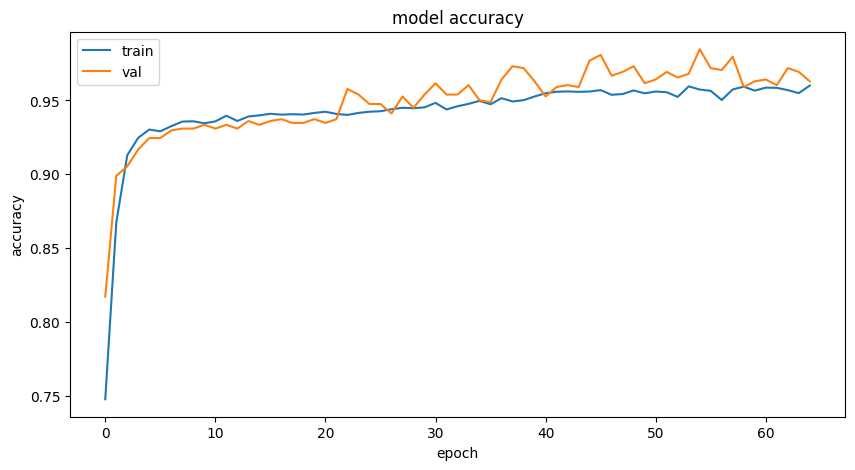

In [ ]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

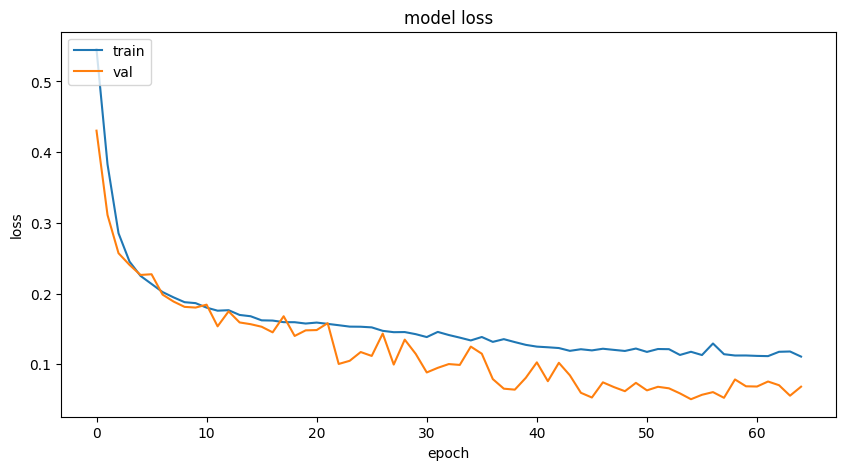

In [ ]:
plot_training_curve(RNN_fwd_2_history,10,5)

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 [==============================] - 2s 7ms/step - loss: 0.0867 - accuracy: 0.9651
Train Accurracy: 0.9650694131851196
79/79 [==============================] - 1s 12ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12372   159]
 [  387  2713]]
Train Precision =  0.9446378830083565 
 Train Recall =  0.8751612903225806


using /kaggle/working/RNN_fwd_2.h5
3/3 - 0s - loss: 0.1355 - accuracy: 0.9355 - 436ms/epoch - 145ms/step
Total time taken for inferencing:  0.53  secs
Test Accurracy: 0.9354838728904724
3/3 [==============================] - 1s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 4 21]]
Test Precision:  0.9130434782608695 
 Test Recall:  0.84 
 Test F1-score: 0.8749999999999999


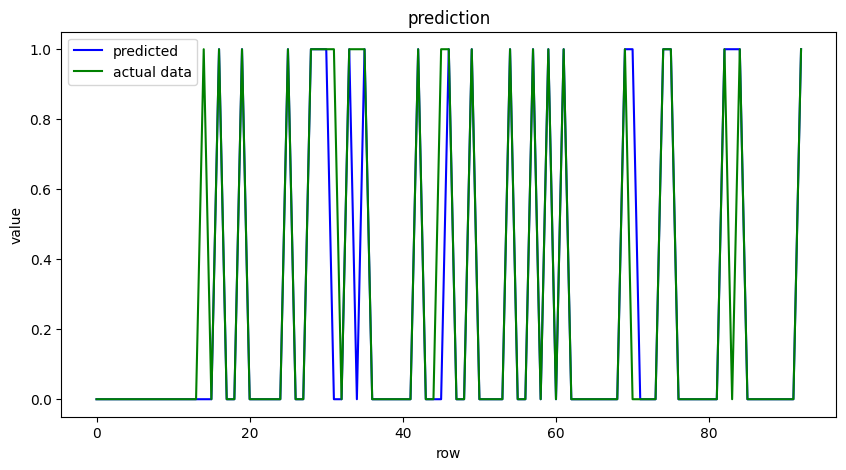

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

In [ ]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = '/kaggle/working/RNN_bi.h5'

Features dimension:  25
Output dimension:  1


In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/200
75/75 - 6s - loss: 0.7120 - accuracy: 0.5574 - val_loss: 0.5447 - val_accuracy: 0.8018 - 6s/epoch - 82ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 3s - loss: 0.5315 - accuracy: 0.7739 - val_loss: 0.4492 - val_accuracy: 0.8018 - 3s/epoch - 36ms/step
Epoch 3/200
75/75 - 3s - loss: 0.3927 - accuracy: 0.8451 - val_loss: 0.3214 - val_accuracy: 0.8772 - 3s/epoch - 42ms/step
Epoch 4/200
75/75 - 2s - loss: 0.2903 - accuracy: 0.9122 - val_loss: 0.2733 - val_accuracy: 0.9143 - 2s/epoch - 33ms/step
Epoch 5/200
75/75 - 3s - loss: 0.2539 - accuracy: 0.9254 - val_loss: 0.2538 - val_accuracy: 0.9169 - 3s/epoch - 34ms/step
Epoch 6/200
75/75 - 2s - loss: 0.2342 - accuracy: 0.9315 - val_loss: 0.2382 - val_accuracy: 0.9182 - 2s/epoch - 32ms/step
Epoch 7/200
75/75 - 3s - loss: 0.2195 - accuracy: 0.9326 - val_loss: 0.2256 - val_accuracy: 0.9207 - 3s/epoch - 46ms/step
Epoch 8/200
75/75 - 2s - loss: 0.2099 - accuracy: 0.9329 - val_loss: 0.2045 - val_accuracy: 0.9207 - 2s/epoch - 32ms/step
Epoch 9/200
75/75 - 2s - loss: 0.2015 - accuracy: 0.9360 - val_loss: 0.1939 - val_accuracy: 0.9246 - 2s/epoch - 30ms/step
Epoch 10/200
75/75 - 2s - loss: 0.19

In [ ]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 50, 12)            384       
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 50, 12)            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 3)                 48        
                                                                 
 dropout_11 (Dropout)        (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 436 (1.70 KB)
Trainable params: 436 (1.70 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

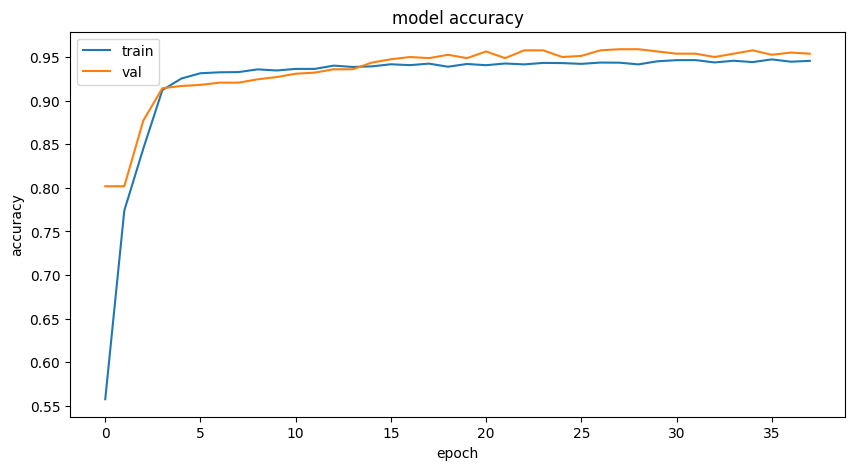

In [ ]:
plot_model_accuracy(RNN_bi_history,10,5)

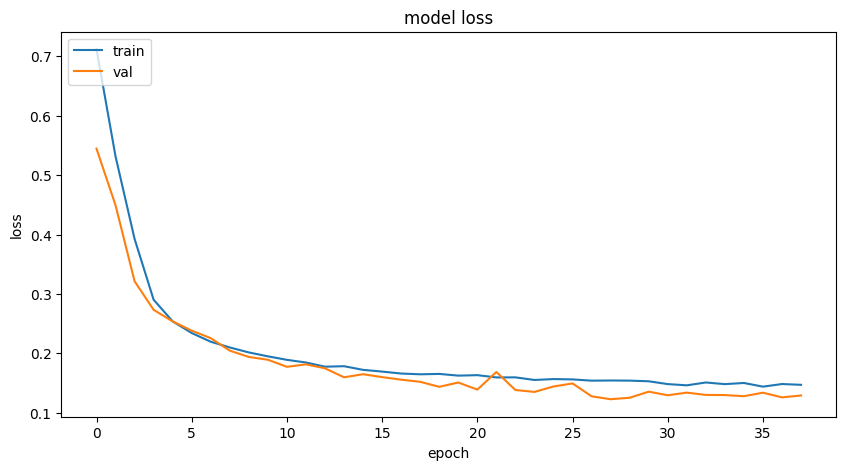

In [ ]:
plot_training_curve(RNN_bi_history,10,5)

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 [==============================] - 5s 17ms/step - loss: 0.1220 - accuracy: 0.9530
Train Accurracy: 0.9530420303344727
79/79 [==============================] - 3s 26ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12209   322]
 [  412  2688]]
Train Precision =  0.8930232558139535 
 Train Recall =  0.8670967741935484


using /kaggle/working/RNN_bi.h5
3/3 - 0s - loss: 0.2233 - accuracy: 0.9032 - 460ms/epoch - 153ms/step
Total time taken for inferencing:  0.55  secs
Test Accurracy: 0.9032257795333862
3/3 [==============================] - 0s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 7 18]]
Test Precision:  0.9 
 Test Recall:  0.72 
 Test F1-score: 0.7999999999999999


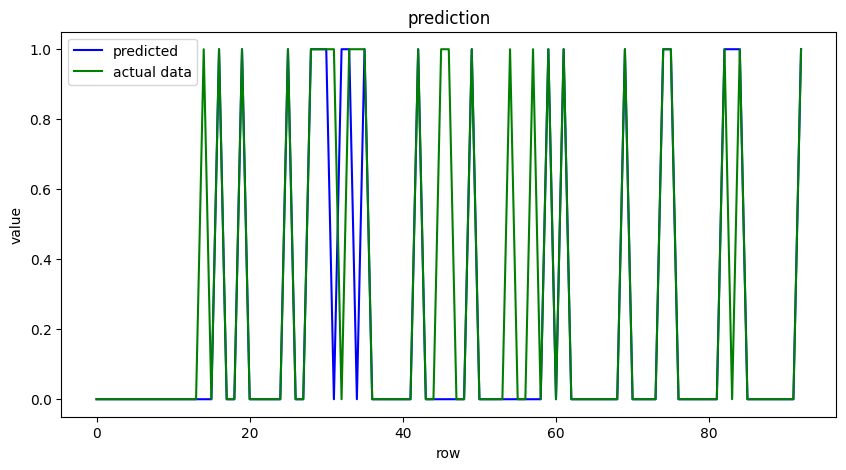

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

In [ ]:
#model = (tf.keras.Sequential([
#        tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.2, input_shape=(x_train.shape[1], 1)),
#        tf.keras.layers.LSTM(50, dropout=0.2),
#        tf.keras.layers.Dense(1, activation="sigmoid"),]))

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = '/kaggle/working/binary_model.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 23s - loss: 0.2497 - accuracy: 0.8976 - val_loss: 0.1409 - val_accuracy: 0.9361 - 23s/epoch - 310ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 18s - loss: 0.1081 - accuracy: 0.9558 - val_loss: 0.0619 - val_accuracy: 0.9821 - 18s/epoch - 237ms/step
Epoch 3/200
75/75 - 19s - loss: 0.0804 - accuracy: 0.9663 - val_loss: 0.0650 - val_accuracy: 0.9693 - 19s/epoch - 250ms/step
Epoch 4/200
75/75 - 18s - loss: 0.0757 - accuracy: 0.9690 - val_loss: 0.0466 - val_accuracy: 0.9885 - 18s/epoch - 245ms/step
Epoch 5/200
75/75 - 19s - loss: 0.0678 - accuracy: 0.9700 - val_loss: 0.0343 - val_accuracy: 0.9898 - 19s/epoch - 255ms/step
Epoch 6/200
75/75 - 18s - loss: 0.0650 - accuracy: 0.9716 - val_loss: 0.0421 - val_accuracy: 0.9821 - 18s/epoch - 239ms/step
Epoch 7/200
75/75 - 22s - loss: 0.0648 - accuracy: 0.9729 - val_loss: 0.0329 - val_accuracy: 0.9885 - 22s/epoch - 296ms/step
Epoch 8/200
75/75 - 19s - loss: 0.0632 - accuracy: 0.9742 - val_loss: 0.0334 - val_accuracy: 0.9898 - 19s/epoch - 247ms/step
Epoch 9/200
75/75 - 19s - loss: 0.0548 - accuracy: 0.9772 - val_loss: 0.0321 - val_accuracy: 0.9910 - 19s/epoch - 260ms/step
Epoch 10/200

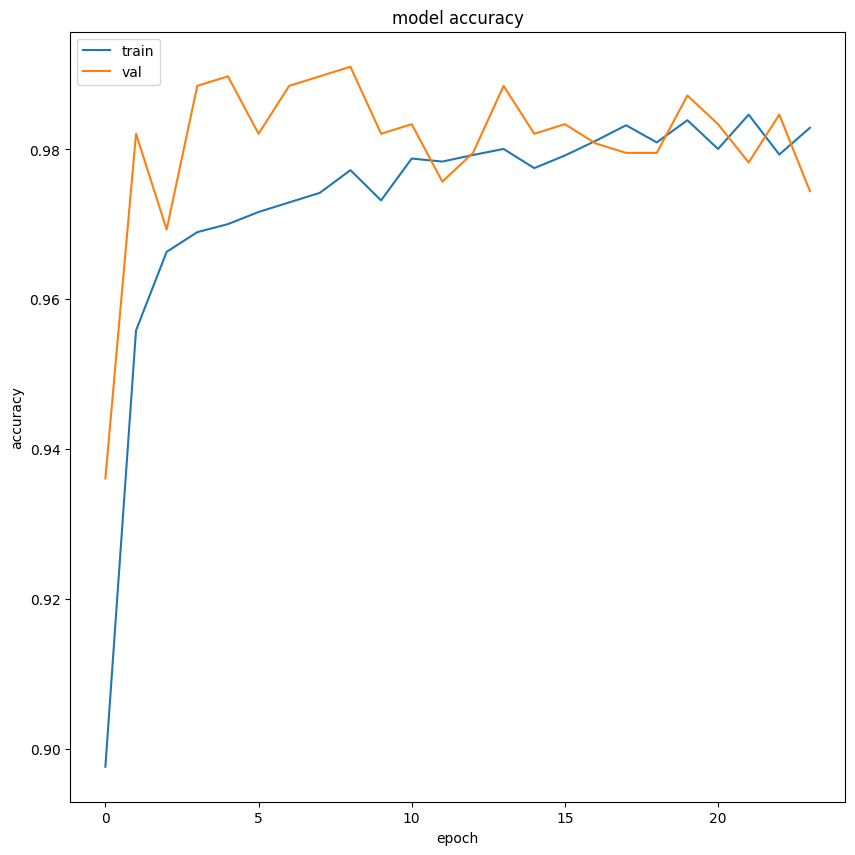

In [ ]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

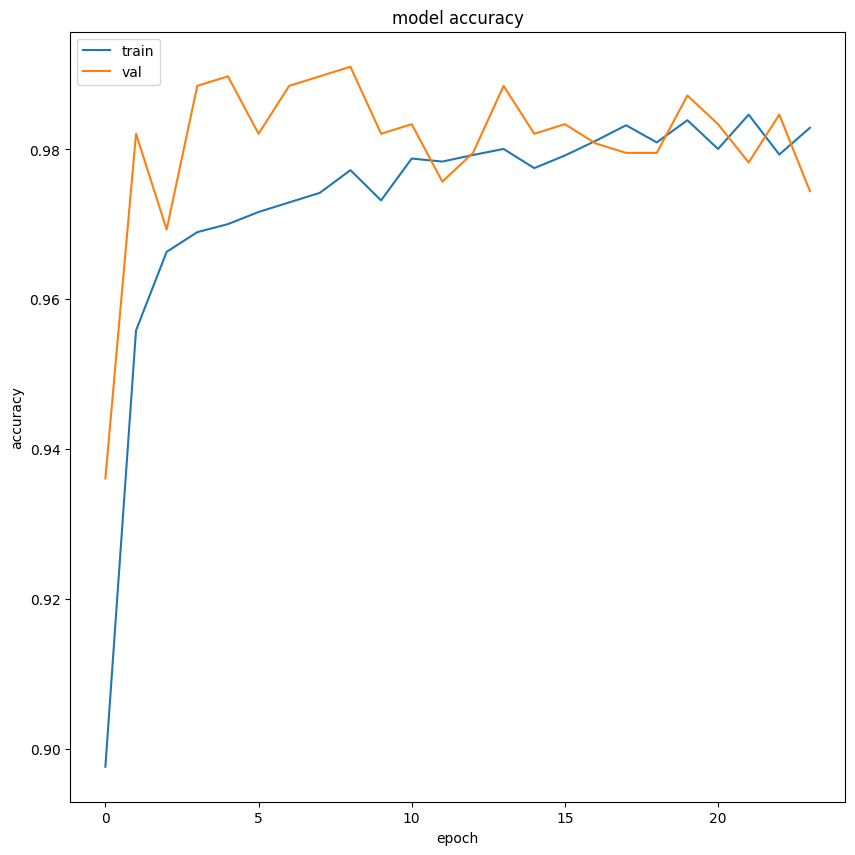

In [ ]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))
# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set
test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 12s 38ms/step - loss: 0.0761 - accuracy: 0.9718
Train Accurracy: 0.9717868566513062
79/79 [==============================] - 9s 107ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12443    88]
 [  353  2747]]
Train Precision =  0.9689594356261023 
 Train Recall =  0.8861290322580645


3/3 - 1s - loss: 0.0370 - accuracy: 0.9785 - 980ms/epoch - 327ms/step
Total time taken for inferencing:  1.04  secs
Test Accurracy: 0.9784946441650391
3/3 [==============================] - 1s 21ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 1 24]]
Test Precision:  0.96 
 Test Recall:  0.96 
 Test F1-score: 0.96


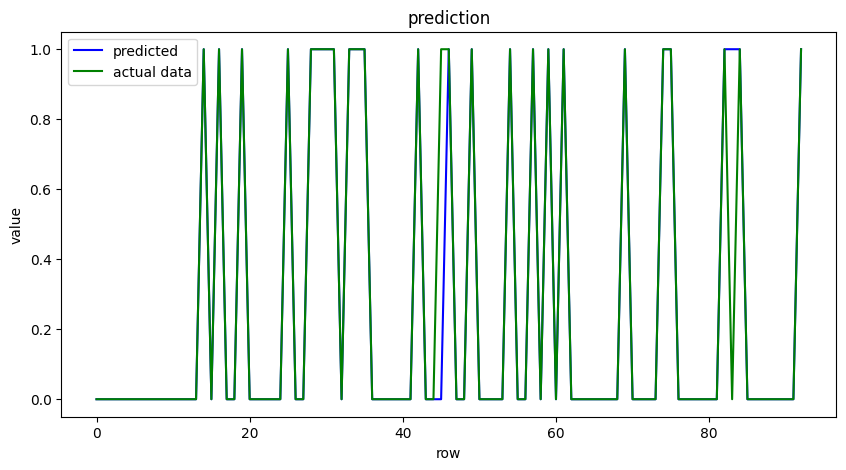

In [ ]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA



In [ ]:
# Generate sequences for training data
def generate_sequences(df, sequence_length, cols):
    seq_gen = (list(df[df['id']==id][cols].values[i-sequence_length:i])
               for id in df['id'].unique() for i in range(sequence_length, len(df[df['id']==id])))
    return np.array(list(seq_gen))

In [ ]:
feature_cols = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional


In [ ]:
# Define RNN models
models = {
    'SimpleRNN': SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    'LSTM': LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    'BidirectionalLSTM': Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2]))
}

In [ ]:
# Train and evaluate RNN models
for name, model in models.items():
    print(f'Training {name}...')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


Training SimpleRNN...


AttributeError: 'SimpleRNN' object has no attribute 'compile'

In [ ]:
X_test = generate_sequences(test_df, sequence_length, feature_cols)
y_test = truth_df.values.ravel()
y_pred = (model.predict(X_test) > 0.5).astype(int)


AttributeError: 'SimpleRNN' object has no attribute 'predict'

In [ ]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'{name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')